In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models
import torchvision.transforms.functional as TF
import zipfile
import json

In [ ]:
!wget -O lars_v1.0.0_images.zip "https://box.vicos.si/lars/lars_v1.0.0_images.zip"

with zipfile.ZipFile("lars_v1.0.0_images.zip", 'r') as zip_ref:
    zip_ref.extractall()

--2026-01-08 20:36:13--  https://box.vicos.si/lars/lars_v1.0.0_images.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013227874 (966M) [application/zip]
Saving to: ‘lars_v1.0.0_images.zip’

lars_v1.0.0_images. 100%[===================>] 966.29M  20.9MB/s    in 47s     

2026-01-08 20:37:00 (20.6 MB/s) - ‘lars_v1.0.0_images.zip’ saved [1013227874/1013227874]



In [ ]:
!wget -O lars_v1.0.0_annotations.zip "https://box.vicos.si/lars/lars_v1.0.0_annotations.zip"

with zipfile.ZipFile("lars_v1.0.0_annotations.zip", 'r') as zip_ref:
    zip_ref.extractall()

--2026-01-08 20:37:45--  https://box.vicos.si/lars/lars_v1.0.0_annotations.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23443553 (22M) [application/zip]
Saving to: ‘lars_v1.0.0_annotations.zip’

lars_v1.0.0_annotat 100%[===================>]  22.36M  9.89MB/s    in 2.3s    

2026-01-08 20:37:48 (9.89 MB/s) - ‘lars_v1.0.0_annotations.zip’ saved [23443553/23443553]



In [ ]:
!ls train

image_annotations.json	images			   panoptic_masks
image_list.txt		panoptic_annotations.json  semantic_masks


# Перед тем как поставить обучаться надолго

## Sematic

In [ ]:
class LaRSSemanticDataset(Dataset):
    def __init__(self, root_dir, split="train", img_size=(256,256)):
        self.split_dir = os.path.join(root_dir, split)
        self.images_dir = os.path.join(self.split_dir, "images")
        self.masks_dir = os.path.join(self.split_dir, "semantic_masks") if split != "test" else None
        list_path = os.path.join(self.split_dir, "image_list.txt")
        with open(list_path, "r") as f:
            self.files = [x.strip() for x in f.readlines()]
        self.img_size = img_size

    def __len__(self):
        return len(self.files)

    def _find_file(self, folder, name):
        for ext in [".png", ".jpg", ".jpeg"]:
            path = os.path.join(folder, name + ext)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"No file found for {name} in {folder}")

    def __getitem__(self, idx):
        name = self.files[idx]
        img_path = self._find_file(self.images_dir, name)
        image = Image.open(img_path).convert("RGB")
        image = TF.resize(image, self.img_size)
        image = TF.to_tensor(image)

        if self.masks_dir:
            mask_path = self._find_file(self.masks_dir, name)
            mask = Image.open(mask_path)
            mask = TF.resize(mask, self.img_size, interpolation=Image.NEAREST)
            mask = torch.from_numpy(np.array(mask)).long()
        else:
            mask = None

        return (image, mask) if mask is not None else image

In [ ]:
train_dataset = LaRSSemanticDataset("/content", split="train", img_size=(256,256))
val_dataset   = LaRSSemanticDataset("/content", split="val", img_size=(256,256))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 3  # obstacle, water, sky
ignore_index = 255

model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:02<00:00, 72.5MB/s]


In [ ]:
def compute_mIoU(pred, target, num_classes=3, ignore_index=255):
    pred = pred.argmax(1)  # [B, H, W]
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    ious = []
    for cls in range(num_classes):
        mask = target != ignore_index
        intersection = np.logical_and(pred==cls, target==cls) & mask
        union = np.logical_or(pred==cls, target==cls) & mask
        if union.sum() == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection.sum() / union.sum())
    return np.nanmean(ious)

In [ ]:
model.train()
for imgs, masks in train_loader:
    imgs = imgs.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    outputs = model(imgs)["out"]  # [B, num_classes, H, W]

    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    miou = compute_mIoU(outputs, masks, num_classes=num_classes)
    print(f"Loss: {loss.item():.4f}, mIoU: {miou:.4f}")

Loss: 1.1437, mIoU: 0.1726
Loss: 1.0322, mIoU: 0.2533
Loss: 0.9222, mIoU: 0.4574
Loss: 0.8249, mIoU: 0.6691
Loss: 0.8034, mIoU: 0.6380
Loss: 0.7706, mIoU: 0.6455
Loss: 0.6792, mIoU: 0.7381
Loss: 0.7186, mIoU: 0.6201
Loss: 0.6032, mIoU: 0.7998
Loss: 0.5496, mIoU: 0.8166
Loss: 0.5215, mIoU: 0.8006
Loss: 0.5155, mIoU: 0.7797
Loss: 0.4520, mIoU: 0.8427
Loss: 0.4124, mIoU: 0.8587
Loss: 0.4560, mIoU: 0.7406
Loss: 0.3602, mIoU: 0.8784
Loss: 0.3883, mIoU: 0.8061
Loss: 0.3198, mIoU: 0.8771
Loss: 0.3005, mIoU: 0.8861
Loss: 0.3080, mIoU: 0.8831
Loss: 0.2635, mIoU: 0.9149
Loss: 0.2643, mIoU: 0.8831
Loss: 0.2502, mIoU: 0.8880
Loss: 0.2638, mIoU: 0.8858
Loss: 0.2637, mIoU: 0.8478
Loss: 0.2119, mIoU: 0.9033
Loss: 0.2315, mIoU: 0.8716
Loss: 0.3511, mIoU: 0.7356
Loss: 0.2256, mIoU: 0.8847
Loss: 0.2441, mIoU: 0.8669
Loss: 0.2182, mIoU: 0.9072
Loss: 0.2132, mIoU: 0.8901
Loss: 0.2095, mIoU: 0.8915
Loss: 0.2158, mIoU: 0.8876
Loss: 0.2121, mIoU: 0.8831
Loss: 0.2106, mIoU: 0.8869
Loss: 0.1670, mIoU: 0.9340
L

In [ ]:
model.eval()
all_miou = []
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)["out"]
        miou = compute_mIoU(outputs, masks, num_classes=num_classes)
        all_miou.append(miou)

print(f"Validation mIoU: {np.mean(all_miou):.4f}")

Validation mIoU: 0.9262


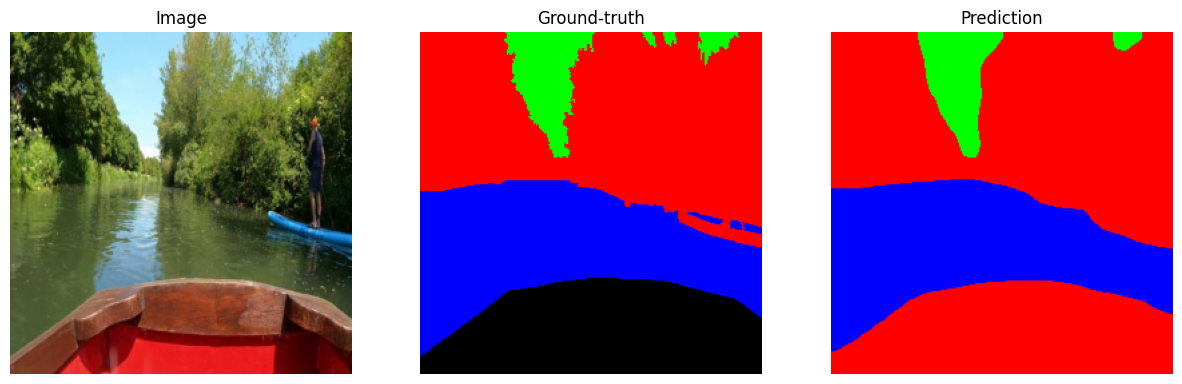

In [ ]:
import matplotlib.pyplot as plt

# Цвета для визуализации: obstacle=красный, water=синий, sky=зелёный
CLASS_COLORS = {
    0: [255, 0, 0],   # obstacle - красный
    1: [0, 0, 255],   # water - синий
    2: [0, 255, 0],   # sky - зелёный
}

def mask_to_rgb(mask):
    """
    Преобразуем [H,W] маску с классами 0,1,2 в RGB изображение
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in CLASS_COLORS.items():
        rgb[mask==cls] = color
    return rgb

# Берем один батч
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)["out"]  # [B, num_classes, H, W]
    preds = outputs.argmax(1).cpu().numpy()  # [B, H, W]

imgs = imgs.cpu().numpy()  # [B,3,H,W]
masks = masks.numpy()      # [B,H,W]

img = np.transpose(imgs[7], (1,2,0))  # HWC
gt_mask = mask_to_rgb(masks[7])
pred_mask = mask_to_rgb(preds[7])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground-truth")
plt.imshow(gt_mask)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred_mask)
plt.axis("off")

plt.show()

## Panoptic

In [ ]:
import os
import json
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.models as models
import matplotlib.pyplot as plt

In [ ]:
class LaRSPanopticDataset(Dataset):
    def __init__(self, root_dir, split="train", img_size=(256,256)):
        self.split_dir = os.path.join(root_dir, split)
        self.images_dir = os.path.join(self.split_dir, "images")
        self.masks_dir = os.path.join(self.split_dir, "panoptic_masks")
        self.img_size = img_size

        # список файлов
        list_path = os.path.join(self.split_dir, "image_list.txt")
        with open(list_path, "r") as f:
            self.files = [x.strip() for x in f.readlines()]

        # Паноптическая аннотация JSON
        ann_path = os.path.join(self.split_dir, "panoptic_annotations.json")
        with open(ann_path, "r") as f:
            self.ann = json.load(f)

        # словарь: filename -> mask id
        self.file_to_mask = {x["file_name"]: x["id"] for x in self.ann["images"]}

        # категории: id -> индекс (0..num_classes-1)
        self.cat_ids = sorted([c["id"] for c in self.ann["categories"]])
        self.id2idx = {cid: i for i, cid in enumerate(self.cat_ids)}

    def __len__(self):
        return len(self.files)

    def _find_file(self, folder, name):
        for ext in [".png", ".jpg", ".jpeg"]:
            path = os.path.join(folder, name + ext)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"No file found for {name} in {folder}")

    def __getitem__(self, idx):
        name = self.files[idx]

        # ---- image ----
        img_path = self._find_file(self.images_dir, name)
        image = Image.open(img_path).convert("RGB")
        image = TF.resize(image, self.img_size)
        image = TF.to_tensor(image)  # [3,H,W]

        # ---- mask ----
        mask_path = self._find_file(self.masks_dir, name)
        mask = Image.open(mask_path)
        mask = TF.resize(mask, self.img_size, interpolation=Image.NEAREST)
        mask = np.array(mask)  # [H,W] или [H,W,3]

        if mask.ndim == 3:  # берем только первый канал
            mask = mask[...,0]

        # переводим ID в индексы 0..num_classes-1
        mask_idx = np.zeros_like(mask, dtype=np.int64)
        for k,v in self.id2idx.items():
            mask_idx[mask==k] = v

        mask_idx = torch.from_numpy(mask_idx)  # [H,W]

        return image, mask_idx

In [ ]:
def compute_mIoU(pred, target, num_classes=11, ignore_index=255):
    """
    pred: [B, num_classes, H, W] logits
    target: [B, H, W] int labels
    """
    pred = pred.argmax(1)  # [B,H,W]
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    ious = []
    for cls in range(num_classes):
        mask = (target != ignore_index)
        intersection = np.logical_and(pred==cls, target==cls) & mask
        union = np.logical_or(pred==cls, target==cls) & mask
        if union.sum() == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection.sum() / union.sum())
    return np.nanmean(ious)

In [ ]:
root_dir = "/content"  # путь к распакованному датасету
img_size = (256,256)
batch_size = 4

In [ ]:
train_dataset = LaRSPanopticDataset(root_dir, split="train", img_size=img_size)
val_dataset   = LaRSPanopticDataset(root_dir, split="val", img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
num_classes = len(train_dataset.cat_ids)
num_classes

11

In [ ]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model.train()
for imgs, masks in train_loader:
    imgs = imgs.to(device)
    masks = masks.to(device).long()  # [B,H,W]

    optimizer.zero_grad()
    outputs = model(imgs)["out"]  # [B,num_classes,H,W]

    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    miou = compute_mIoU(outputs, masks, num_classes=num_classes)
    print(f"Loss: {loss.item():.4f}, mIoU: {miou:.4f}")

Loss: 2.5276, mIoU: 0.0015
Loss: 2.2657, mIoU: 0.0442
Loss: 2.2405, mIoU: 0.0313
Loss: 2.1069, mIoU: 0.1088
Loss: 2.0095, mIoU: 0.1327
Loss: 1.9718, mIoU: 0.1715
Loss: 1.8759, mIoU: 0.2023
Loss: 1.7942, mIoU: 0.2340
Loss: 1.7770, mIoU: 0.2228
Loss: 1.6961, mIoU: 0.2558
Loss: 1.7385, mIoU: 0.1955
Loss: 1.6215, mIoU: 0.2474
Loss: 1.5001, mIoU: 0.2525
Loss: 1.3738, mIoU: 0.3219
Loss: 1.4259, mIoU: 0.2810
Loss: 1.5712, mIoU: 0.2079
Loss: 1.3349, mIoU: 0.2514
Loss: 1.3053, mIoU: 0.3227
Loss: 1.3143, mIoU: 0.2506
Loss: 1.1480, mIoU: 0.4178
Loss: 1.2672, mIoU: 0.3023
Loss: 1.0909, mIoU: 0.3174
Loss: 1.0175, mIoU: 0.4448
Loss: 1.0084, mIoU: 0.5159
Loss: 0.9953, mIoU: 0.4483
Loss: 0.9704, mIoU: 0.3092
Loss: 1.0298, mIoU: 0.3430
Loss: 1.1871, mIoU: 0.2871
Loss: 1.0094, mIoU: 0.3193
Loss: 0.9406, mIoU: 0.5720
Loss: 0.8296, mIoU: 0.5308
Loss: 0.9351, mIoU: 0.4846
Loss: 0.7885, mIoU: 0.4553
Loss: 0.8880, mIoU: 0.3881
Loss: 0.9185, mIoU: 0.4598
Loss: 0.8423, mIoU: 0.6406
Loss: 0.9617, mIoU: 0.3787
L

In [ ]:
model.eval()
all_miou = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).long()

        outputs = model(imgs)["out"]
        miou = compute_mIoU(outputs, masks, num_classes=num_classes)
        all_miou.append(miou)

print(f"Validation mIoU: {np.mean(all_miou):.4f}")

Validation mIoU: 0.5248


In [ ]:
def visualize_prediction(img_tensor, pred_mask, true_mask=None):
    """
    img_tensor: [3,H,W]
    pred_mask: [H,W] индекс классов
    true_mask: [H,W] индекс классов (опционально)
    """
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # палитра для 11 классов
    colors = np.array([
        [0,0,0],        # класс 0
        [255,0,0],      # класс 1
        [0,255,0],      # класс 2
        [0,0,255],      # класс 3
        [255,255,0],    # класс 4
        [255,0,255],    # класс 5
        [0,255,255],    # класс 6
        [128,128,0],    # класс 7
        [128,0,128],    # класс 8
        [0,128,128],    # класс 9
        [128,128,128],  # класс 10
    ])

    pred_color = colors[pred_mask.cpu().numpy()]
    if true_mask is not None:
        true_color = colors[true_mask.cpu().numpy()]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Pred Mask")
    plt.imshow(pred_color)
    plt.axis("off")

    if true_mask is not None:
        plt.subplot(1,3,3)
        plt.title("True Mask")
        plt.imshow(true_color)
        plt.axis("off")

    plt.show()

In [ ]:
def vizualize_by_idx(idx):
  model.eval()
  with torch.no_grad():
      img, mask = val_dataset[idx]           # img: [3,H,W], mask: [H,W]
      img = img.to(device).unsqueeze(0)     # добавляем batch dimension [1,3,H,W]
      output = model(img)["out"]            # [1,num_classes,H,W]
      pred = output.argmax(1)[0]            # убираем batch dimension -> [H,W]

      visualize_prediction(img[0], pred, mask)

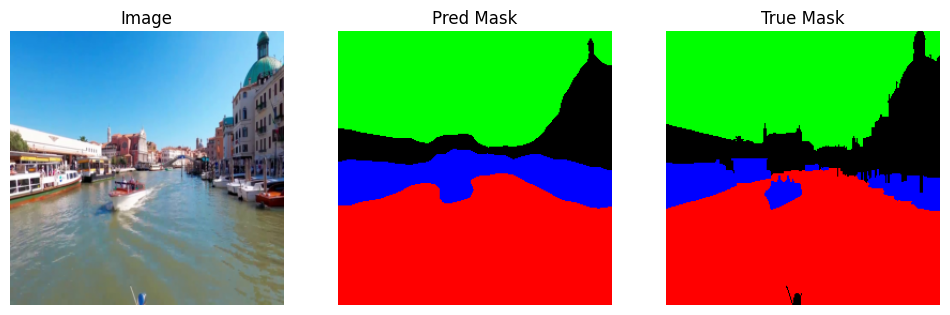

In [ ]:
vizualize_by_idx(1)

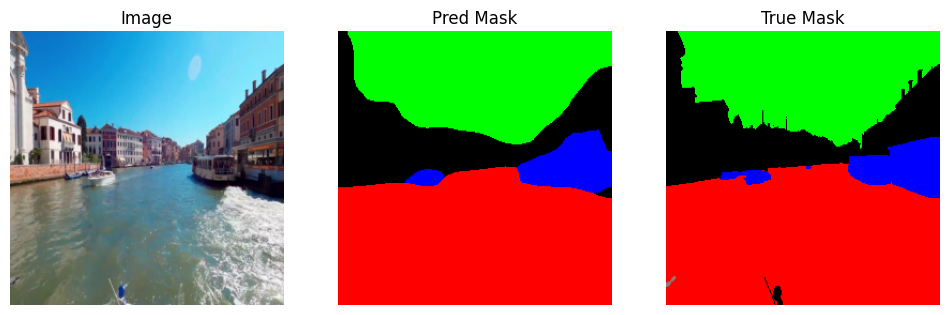

In [ ]:
vizualize_by_idx(2)

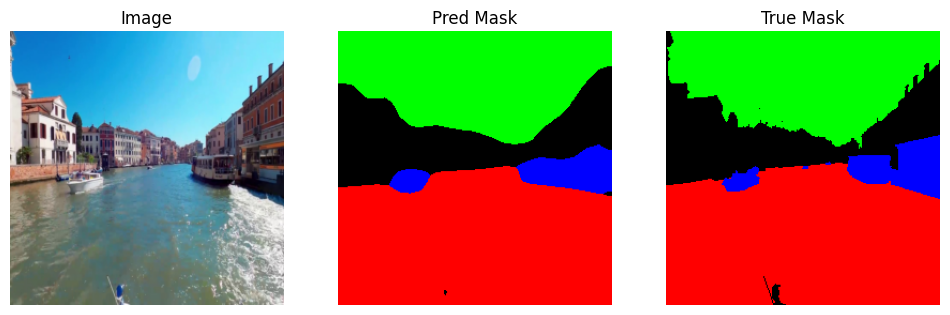

In [ ]:
vizualize_by_idx(3)

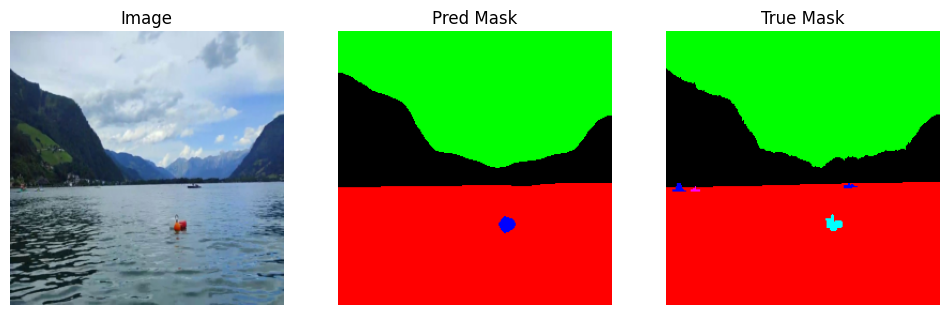

In [ ]:
vizualize_by_idx(6)

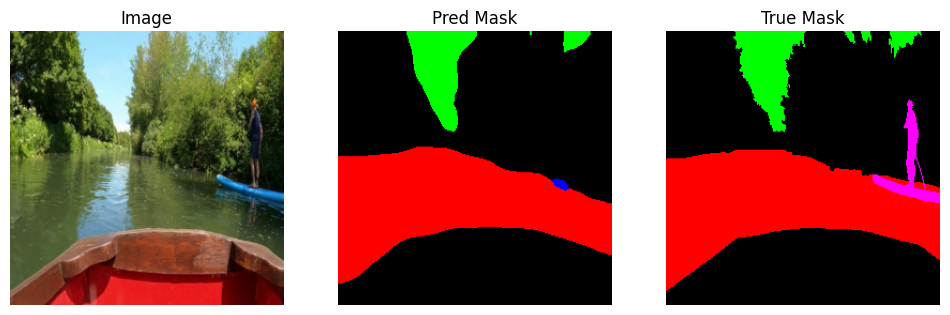

In [ ]:
vizualize_by_idx(7)

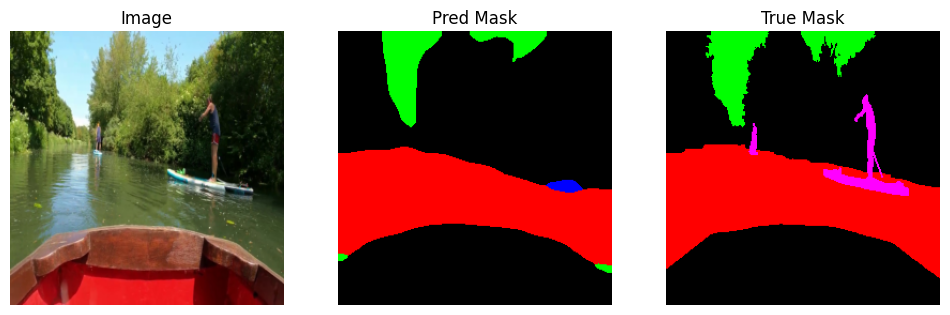

In [ ]:
vizualize_by_idx(8)

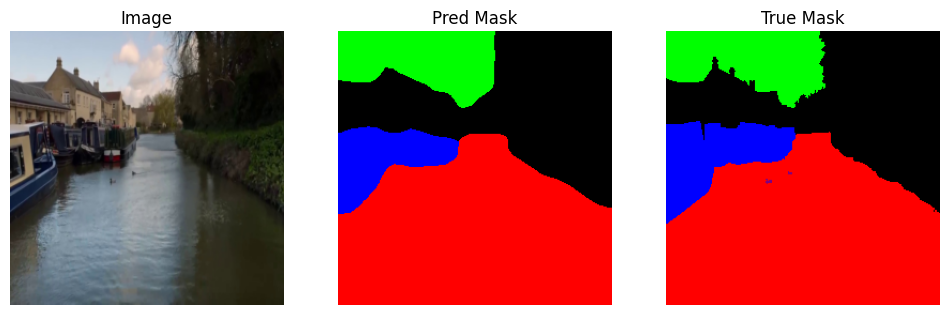

In [ ]:
vizualize_by_idx(9)

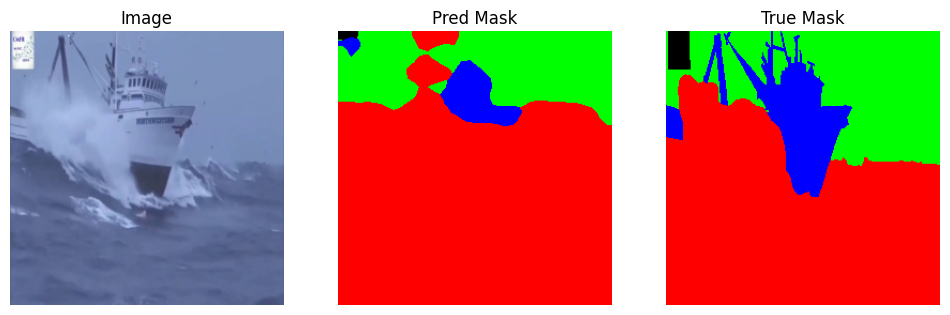

In [ ]:
vizualize_by_idx(10)

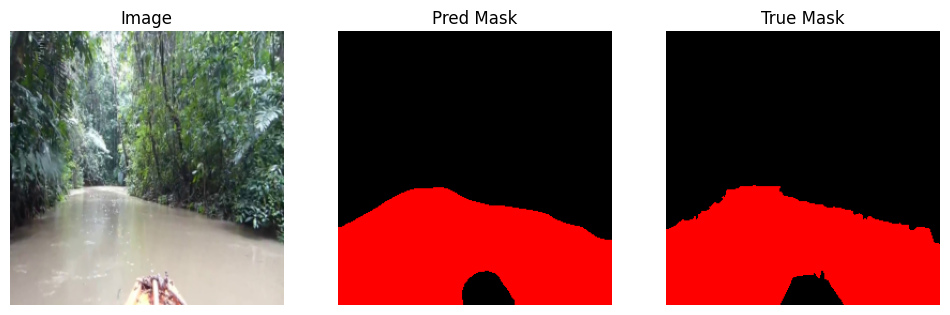

In [ ]:
vizualize_by_idx(12)

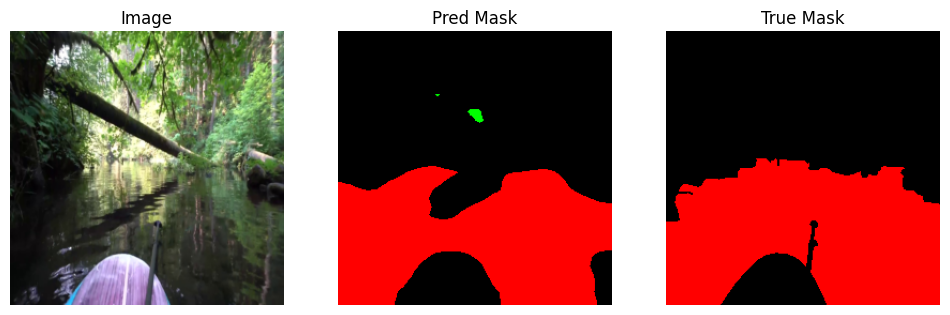

In [ ]:
vizualize_by_idx(15)

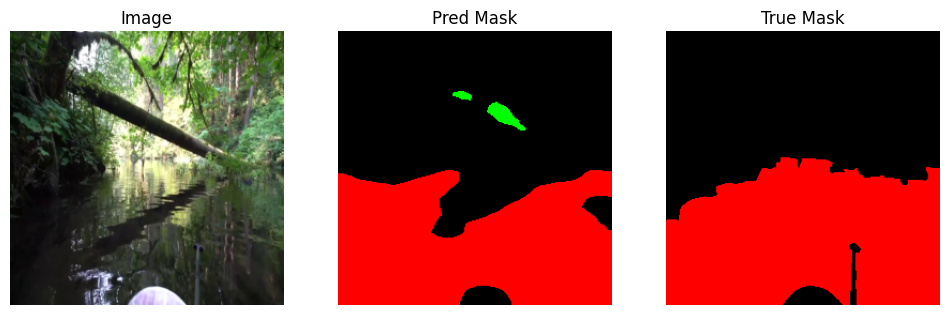

In [ ]:
vizualize_by_idx(16)

## Подбор гиперпараметров

In [ ]:
from itertools import product

learning_rates = [1e-3, 1e-4]
batch_sizes = [2, 4]

best_miou = 0
best_params = None

for lr, bs in product(learning_rates, batch_sizes):
    print(f"Testing lr={lr}, batch_size={bs}")

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=2, drop_last=True)

    model = models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # быстрая эпоха
    model.train()
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).long()
        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # оценка на валидации
    model.eval()
    miou_list = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device).long()
            outputs = model(imgs)["out"]
            miou = compute_mIoU(outputs, masks, num_classes=num_classes)
            miou_list.append(miou)
    avg_miou = np.mean(miou_list)
    print(f"Validation mIoU: {avg_miou:.4f}")

    if avg_miou > best_miou:
        best_miou = avg_miou
        best_params = (lr, bs)

print("Best params:", best_params, "with mIoU:", best_miou)

Testing lr=0.001, batch_size=2


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation mIoU: 0.4923
Testing lr=0.001, batch_size=4
Validation mIoU: 0.4597
Testing lr=0.0001, batch_size=2
Validation mIoU: 0.5492
Testing lr=0.0001, batch_size=4
Validation mIoU: 0.5500
Best params: (0.0001, 4) with mIoU: 0.54997500057156


# Обучение

In [1]:
import os
import json
import zipfile
from tqdm import tqdm
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T
import torchvision.transforms.functional as TF

device = "cuda" if torch.cuda.is_available() else "cpu"

num_epochs = 30
lr = 1e-4
batch_size = 4

print("Device:", device)

Device: cuda


In [2]:
!wget -O lars_v1.0.0_images.zip "https://box.vicos.si/lars/lars_v1.0.0_images.zip"

with zipfile.ZipFile("lars_v1.0.0_images.zip", 'r') as zip_ref:
    zip_ref.extractall()

!wget -O lars_v1.0.0_annotations.zip "https://box.vicos.si/lars/lars_v1.0.0_annotations.zip"

with zipfile.ZipFile("lars_v1.0.0_annotations.zip", 'r') as zip_ref:
    zip_ref.extractall()

--2026-01-09 15:30:55--  https://box.vicos.si/lars/lars_v1.0.0_images.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013227874 (966M) [application/zip]
Saving to: ‘lars_v1.0.0_images.zip’

lars_v1.0.0_images. 100%[===================>] 966.29M  20.1MB/s    in 50s     

2026-01-09 15:31:46 (19.3 MB/s) - ‘lars_v1.0.0_images.zip’ saved [1013227874/1013227874]

--2026-01-09 15:31:51--  https://box.vicos.si/lars/lars_v1.0.0_annotations.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23443553 (22M) [application/zip]
Saving to: ‘lars_v1.0.0_annotations.zip’

lars_v1.0.0_annotat 100%[===================>]  22.36M  10.1MB/s    in 2.2s    

2026-01-09 15:31:54 (10.1 MB/s) - ‘lars_v1.0.0_annotations.zip’ saved [23

In [3]:
class LaRSPanopticDataset(Dataset):
    def __init__(self, root_dir, split="train", img_size=(256,256)):
        self.split_dir = os.path.join(root_dir, split)
        self.images_dir = os.path.join(self.split_dir, "images")
        self.masks_dir = os.path.join(self.split_dir, "panoptic_masks")
        self.img_size = img_size

        # список файлов
        list_path = os.path.join(self.split_dir, "image_list.txt")
        with open(list_path, "r") as f:
            self.files = [x.strip() for x in f.readlines()]

        # Паноптическая аннотация JSON
        ann_path = os.path.join(self.split_dir, "panoptic_annotations.json")
        with open(ann_path, "r") as f:
            self.ann = json.load(f)

        # словарь: filename -> mask id
        self.file_to_mask = {x["file_name"]: x["id"] for x in self.ann["images"]}

        # категории: id -> индекс (0..num_classes-1)
        self.cat_ids = sorted([c["id"] for c in self.ann["categories"]])
        self.id2idx = {cid: i for i, cid in enumerate(self.cat_ids)}

    def __len__(self):
        return len(self.files)

    def _find_file(self, folder, name):
        for ext in [".png", ".jpg", ".jpeg"]:
            path = os.path.join(folder, name + ext)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"No file found for {name} in {folder}")

    def __getitem__(self, idx):
        name = self.files[idx]

        # ---- image ----
        img_path = self._find_file(self.images_dir, name)
        image = Image.open(img_path).convert("RGB")
        image = TF.resize(image, self.img_size)
        image = TF.to_tensor(image)  # [3,H,W]

        # ---- mask ----
        mask_path = self._find_file(self.masks_dir, name)
        mask = Image.open(mask_path)
        mask = TF.resize(mask, self.img_size, interpolation=Image.NEAREST)
        mask = np.array(mask)  # [H,W] или [H,W,3]

        if mask.ndim == 3:  # берем только первый канал
            mask = mask[...,0]

        # переводим ID в индексы 0..num_classes-1
        mask_idx = np.zeros_like(mask, dtype=np.int64)
        for k,v in self.id2idx.items():
            mask_idx[mask==k] = v

        mask_idx = torch.from_numpy(mask_idx)  # [H,W]

        return image, mask_idx

In [4]:
root_dir = "/content"
img_size = (256,256)
batch_size = 4

In [5]:
train_dataset = LaRSPanopticDataset(root_dir, split="train", img_size=img_size)
val_dataset   = LaRSPanopticDataset(root_dir, split="val", img_size=img_size)

In [6]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [7]:
def compute_mIoU(pred, target, num_classes, ignore_index=255):
    pred = pred.argmax(1)  # [B,H,W]
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    ious = []
    for cls in range(num_classes):
        pred_i = pred == cls
        target_i = target == cls

        mask = target != ignore_index
        intersection = np.logical_and(pred_i, target_i) & mask
        union = np.logical_or(pred_i, target_i) & mask

        if union.sum() == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection.sum() / union.sum())

    return np.nanmean(ious)

In [8]:
def train_model(model, model_name):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_miou = 0.0

    for epoch in range(num_epochs):
        print(f"\n[{model_name}] Epoch {epoch+1}/{num_epochs}")

        # ===== TRAIN =====
        model.train()
        train_losses = []
        train_mious = []

        for imgs, masks in tqdm(train_loader):
            imgs = imgs.to(device)
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(imgs)["out"]

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            miou = compute_mIoU(outputs, masks, num_classes)

            train_losses.append(loss.item())
            train_mious.append(miou)

        print(
            f"Train | Loss: {np.mean(train_losses):.4f}, "
            f"mIoU: {np.mean(train_mious):.4f}"
        )

        # ===== VALIDATION =====
        model.eval()
        val_mious = []

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device).long()

                outputs = model(imgs)["out"]
                miou = compute_mIoU(outputs, masks, num_classes)
                val_mious.append(miou)

        val_miou = np.mean(val_mious)
        print(f"Val   | mIoU: {val_miou:.4f}")

        # ===== SAVE BEST =====
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(
                model.state_dict(),
                f"{model_name}_best.pth"
            )
            print(f"🔥 Saved best model ({best_miou:.4f})")

    print(f"\n✅ {model_name} finished. Best mIoU: {best_miou:.4f}")

In [9]:
num_classes = 11

In [ ]:
model1 = models.segmentation.deeplabv3_resnet50(pretrained=True)
model1.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

train_model(model1, "DeepLabV3_ResNet50")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 170MB/s]



[DeepLabV3_ResNet50] Epoch 1/30


100%|██████████| 651/651 [03:47<00:00,  2.86it/s]

Train | Loss: 0.3152, mIoU: 0.4920


Val   | mIoU: 0.5507
🔥 Saved best model (0.5507)

[DeepLabV3_ResNet50] Epoch 2/30


100%|██████████| 651/651 [03:51<00:00,  2.82it/s]

Train | Loss: 0.1191, mIoU: 0.5544


Val   | mIoU: 0.5702
🔥 Saved best model (0.5702)

[DeepLabV3_ResNet50] Epoch 3/30


100%|██████████| 651/651 [03:50<00:00,  2.83it/s]

Train | Loss: 0.0852, mIoU: 0.5690


Val   | mIoU: 0.5685

[DeepLabV3_ResNet50] Epoch 4/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0716, mIoU: 0.5830


Val   | mIoU: 0.5679

[DeepLabV3_ResNet50] Epoch 5/30


100%|██████████| 651/651 [03:50<00:00,  2.83it/s]

Train | Loss: 0.0616, mIoU: 0.5886


Val   | mIoU: 0.5470

[DeepLabV3_ResNet50] Epoch 6/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0538, mIoU: 0.5947


Val   | mIoU: 0.5840
🔥 Saved best model (0.5840)

[DeepLabV3_ResNet50] Epoch 7/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0546, mIoU: 0.5913


Val   | mIoU: 0.5512

[DeepLabV3_ResNet50] Epoch 8/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0624, mIoU: 0.5843


Val   | mIoU: 0.5523

[DeepLabV3_ResNet50] Epoch 9/30


100%|██████████| 651/651 [03:50<00:00,  2.83it/s]

Train | Loss: 0.0507, mIoU: 0.5920


Val   | mIoU: 0.5907
🔥 Saved best model (0.5907)

[DeepLabV3_ResNet50] Epoch 10/30


100%|██████████| 651/651 [03:50<00:00,  2.83it/s]

Train | Loss: 0.0509, mIoU: 0.6004


Val   | mIoU: 0.5841

[DeepLabV3_ResNet50] Epoch 11/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0521, mIoU: 0.6007


Val   | mIoU: 0.5732

[DeepLabV3_ResNet50] Epoch 12/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0443, mIoU: 0.6188


Val   | mIoU: 0.5810

[DeepLabV3_ResNet50] Epoch 13/30


100%|██████████| 651/651 [03:49<00:00,  2.83it/s]

Train | Loss: 0.0379, mIoU: 0.6236


Val   | mIoU: 0.5799

[DeepLabV3_ResNet50] Epoch 14/30


  3%|▎         | 22/651 [00:07<03:39,  2.86it/s]

In [ ]:
model2 = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
model2.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

train_model(model2, "DeepLabV3_MobileNetV3")

In [ ]:
from google.colab import files
files.download("DeepLabV3_ResNet50_best.pth")
files.download("DeepLabV3_MobileNetV3_best.pth")

In [ ]:
while True: pass